In [1]:
# import wandb

# api = wandb.Api()
# run = api.run("jan-p-fidor/cxr_covid/runs/zxp0jhf4")
# run.group = "weak"
# run.update()

In [2]:
import torch

cpt = torch.load("checkpoints/dataset3.densenet121.30497.pkl.best_auroc", weights_only=False)
model = cpt["model"]

tensor = torch.load("data/tensors/bimcv+/sub-S03306_ses-E06508_run-1_bp-chest_vp-pa_dx.pt", weights_only=True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize_img(image):
    img = image.numpy().transpose((1, 2, 0))  # numpy is [h, w, c] 
    _mean = np.array(mean)  # mean of your dataset
    _std = np.array(std)  # std of your dataset
    img = _std * img + _mean
    return img

def show_img(image):
    plt.imshow(image)
    plt.show()
    

In [4]:
from pytorch_grad_cam import GradCAMPlusPlus, EigenCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def gradcam_mask(tensor, label, gradcam):
    numpy_img = denormalize_img(tensor)

    attention = gradcam(input_tensor=tensor.clone().unsqueeze(0), targets=[ClassifierOutputTarget(label)])
    visualization = show_cam_on_image(numpy_img.clip(0, 1), attention[0], use_rgb=True)

    return visualization, attention[0]

gradcam_layers = [
    model.features[-2].denselayer16.conv2
]
gradcam1 = GradCAMPlusPlus(model=model, target_layers=gradcam_layers)
gradcam2 = EigenCAM(model=model, target_layers=gradcam_layers)
gradcam3 = EigenGradCAM(model=model, target_layers=gradcam_layers)


/home/janfidor/anaconda3/envs/cxr/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


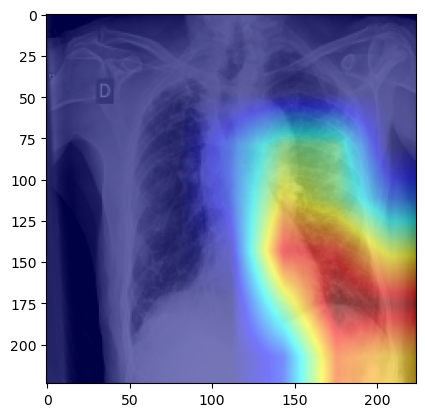

In [5]:
import seaborn as sn
vis, att = gradcam_mask(tensor, 1, gradcam3)
show_img(vis)

In [6]:
from torchmetrics import JaccardIndex

def treshold_intersection(att1, att2, treshold):
    tresh1 = (att1 > treshold)
    tresh2 = (att2 > treshold)

    jaccard = JaccardIndex(task='multiclass', num_classes=2)
    return jaccard(torch.tensor(tresh1), torch.tensor(tresh2))


/home/janfidor/anaconda3/envs/cxr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import seaborn as sn


vis1, att1 = gradcam_mask(tensor, 1, gradcam1)
vis2, att2 = gradcam_mask(tensor, 1, gradcam2)
vis3, att3 = gradcam_mask(tensor, 1, gradcam3)

In [8]:
att1.shape, att2.shape, att3.shape

((224, 224), (224, 224), (224, 224))

In [9]:
treshold_intersection(att1, att3, 0.7)

tensor(0.7644)

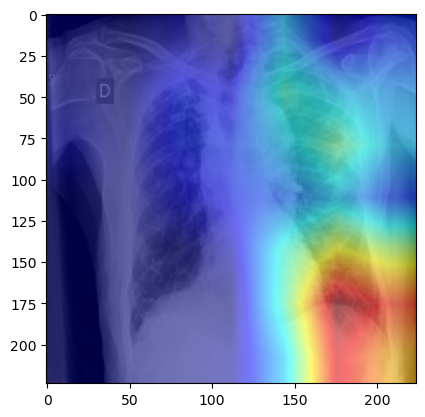

In [10]:
show_img(vis1)

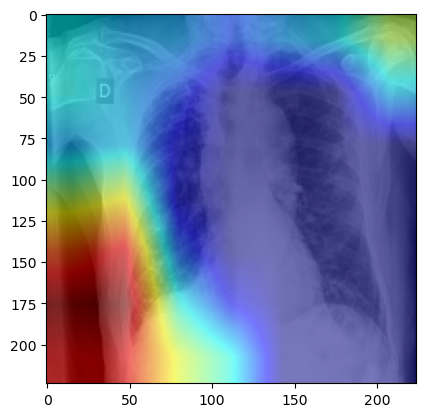

In [11]:
show_img(vis2)

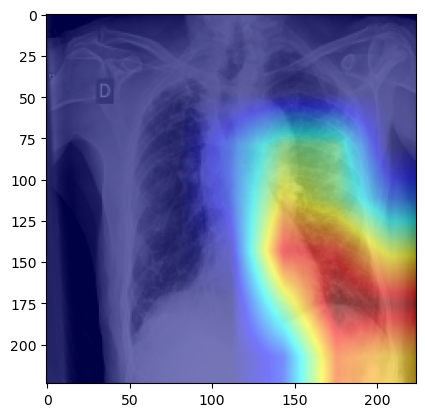

In [12]:
show_img(vis3)